In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

In [2]:
def plot_labelled_bb(impath, bblist, title=None, text_size='large',
                     mode='path', omode='screen', opath=None,
                     figsize=(10, 20), show_image=True, ax=None):
    '''nabbed from clp-vision'''

    if mode == 'path':
        img = plt.imread(impath)
    elif mode == 'img':
        img = impath

    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = plt.gcf()

    fig.set_size_inches(figsize)

    if not show_image:
        img = np.ones_like(img) * 255
        # img = np.zeros_like(img)
    ax.imshow(img)

    if bblist is not None:
        for (this_bb, this_label) in bblist:
            x, y, w, h = this_bb

            if type(this_label) == tuple:
                edgecolor = this_label[1]
                this_label = this_label[0]
            else:
                edgecolor = 'r'
            ax.add_patch(
                matplotlib.patches.Rectangle(
                    (x, y),
                    w,
                    h,
                    edgecolor=edgecolor,
                    fill=False, linewidth=4
                )
            )
            if this_label != '':
                ax.text(x, y, this_label, size=text_size, style='italic',
                        bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 10})
    if title is not None:
        ax.set_title(title)

    if show_image:
        ax.axis('off')
    else:
        ax.tick_params(
            axis='both',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False,
            left=False,
            labelleft=False)  # labels along the bottom edge are off

    if omode == 'img':
        fig.savefig(opath, bbox_inches='tight', pad_inches=0)
        plt.close()  # to supress showing the plot in interactive mode

In [3]:
spelldf = pd.read_json('all_responses_round0-3_cleaned.json.gz', orient='split')

In [4]:
len(spelldf), spelldf.columns

(25315,
 Index(['vg_img_id', 'cat', 'synset', 'vg_obj_name', 'responses_r0', 'opt-outs',
        'vg_domain', 'top_response_domain_r0', 'responses_domains_r0', 'url',
        'sample_type', 'responses_domains_r1', 'responses_r1',
        'top_response_domain_r1', 'responses_domains_r2', 'responses_r2',
        'top_response_domain_r2', 'responses_domains_r3', 'responses_r3',
        'top_response_domain_r3', 'vg_object_id', 'all_responses', 'clean',
        'canon', 'spellchecked'],
       dtype='object'))

In [5]:
vgobjdf = pd.read_json('../dsg-repos/dsg-vision/Preproc/PreprocOut/vgobjdf.json.gz', orient='split')

In [6]:
len(vgobjdf), vgobjdf.columns

(3895567,
 Index(['i_corpus', 'image_id', 'obj_id', 'syn', 'name', 'bb'], dtype='object'))

In [7]:
fulldf = spelldf.merge(vgobjdf, how='left', left_on=['vg_img_id', 'vg_object_id', 'vg_obj_name'], 
                       right_on=['image_id', 'obj_id', 'name'])
imagedf = vgobjdf[vgobjdf.image_id.isin(spelldf.vg_img_id)]

In [8]:
len(imagedf), imagedf.columns, len(fulldf), fulldf.columns

(885488,
 Index(['i_corpus', 'image_id', 'obj_id', 'syn', 'name', 'bb'], dtype='object'),
 25315,
 Index(['vg_img_id', 'cat', 'synset', 'vg_obj_name', 'responses_r0', 'opt-outs',
        'vg_domain', 'top_response_domain_r0', 'responses_domains_r0', 'url',
        'sample_type', 'responses_domains_r1', 'responses_r1',
        'top_response_domain_r1', 'responses_domains_r2', 'responses_r2',
        'top_response_domain_r2', 'responses_domains_r3', 'responses_r3',
        'top_response_domain_r3', 'vg_object_id', 'all_responses', 'clean',
        'canon', 'spellchecked', 'i_corpus', 'image_id', 'obj_id', 'syn',
        'name', 'bb'],
       dtype='object'))

In [14]:
def iou(box_a, box_b):
    # (x,y) coordinates of intersection
    xa = max(box_a[0], box_b[0])
    ya = max(box_a[1], box_b[1])
    xb = min(box_a[2], box_b[2])
    yb = min(box_a[3], box_b[3])
    
    # compute the area of intersection rectangle
    intersect = max(0, xb - xa + 1) * max(0, yb - ya + 1)
 
    # total area of both bbs
    area_a = (box_a[2] - box_a[0] + 1) * (box_a[3] - box_a[1] + 1)
    area_b = (box_b[2] - box_b[0] + 1) * (box_b[3] - box_b[1] + 1)
 
    #failsafe for no overlap
    if intersect == 0:
        return 0
    
    return intersect / (area_a + area_b - intersect)

In [15]:
iou([20, 20, 80, 80], [0, 0, 100, 100])

0.3647681599843153

In [16]:
def interfering_objects(fulldf, vgobjdf, domain_blacklist, iou_threshold=0.0):
    overlaps = []
    print(len(fulldf))
    fulldf = fulldf[fulldf.vg_domain.apply(lambda d: d not in domain_blacklist)]
    print(len(fulldf))
    for n, trial in fulldf.iterrows():
        imgid = trial['vg_img_id']
        bb_test = trial['bb']
        name_test = trial['vg_obj_name']

        tempdf = vgobjdf[vgobjdf.image_id == imgid]
        for n, obj in tempdf.iterrows():
            #print(obj['name'], obj['bb'])
            o_name = obj['name']
            if trial['obj_id'] != obj['obj_id'] and \
               name_test != o_name and \
               o_name in trial['spellchecked'] and \
               iou(bb_test, obj['bb']) > iou_threshold:
                overlaps.append((imgid, trial['obj_id'], obj['obj_id'], name_test, o_name, 
                                bb_test, obj['bb'], trial['spellchecked']))
    return overlaps

In [17]:
blacklist = ['people']

In [18]:
inf_objects = interfering_objects(fulldf, vgobjdf, blacklist)

25315
20782


In [19]:
infdf = pd.DataFrame(inf_objects, columns='img_id obj_id_a obj_id_b name_a name_b bb_a bb_b spellchecked'.split())

In [20]:
infdf.head(10)

,img_id,obj_id_a,obj_id_b,name_a,name_b,bb_a,bb_b,spellchecked
0,2378759,1365136,1365138,jacket,man,"[0, 215, 171, 285]","[9, 197, 185, 303]","{'jacket': 14, 'man': 11, 'person': 2, 'sweats..."
1,2378759,1365136,1365138,jacket,person,"[0, 215, 171, 285]","[9, 197, 185, 303]","{'jacket': 14, 'man': 11, 'person': 2, 'sweats..."
2,2394825,460665,460632,salad,food,"[50, 55, 346, 233]","[47, 16, 395, 302]","{'dinner': 1, 'carrot': 1, 'veggies': 1, 'food..."
3,2411079,316928,316921,tub,dog,"[0, 0, 290, 132]","[194, 74, 304, 179]","{'tub': 10, 'fence': 1, 'bed': 2, 'bathtub': 1..."
4,2351178,2398820,2218813,car,truck,"[18, 58, 408, 424]","[26, 82, 403, 410]","{'vehicle': 1, 'pickup truck': 2, 'truck': 28,..."
5,2415935,3077264,2793997,train,pillar,"[0, 67, 497, 183]","[1, 10, 34, 215]","{'train': 31, 'subway car': 1, 'poles': 1, 'pi..."
6,2319978,3393197,2720555,airplane,plane,"[3, 24, 451, 226]","[10, 18, 475, 269]","{'plane': 15, 'jet': 2, 'jet plane': 1, 'airpl..."
7,2319978,3393197,3419208,airplane,plane,"[3, 24, 451, 226]","[24, 56, 407, 247]","{'plane': 15, 'jet': 2, 'jet plane': 1, 'airpl..."
8,2319978,3393197,3118936,airplane,plane,"[3, 24, 451, 226]","[0, 26, 456, 221]","{'plane': 15, 'jet': 2, 'jet plane': 1, 'airpl..."
9,2319978,3393197,3292076,airplane,plane,"[3, 24, 451, 226]","[11, 30, 455, 237]","{'plane': 15, 'jet': 2, 'jet plane': 1, 'airpl..."


In [21]:
len(infdf), len(spelldf)

(15440, 25315)

In [22]:
def labeled_bbs(df, object_id):
    imgdf = df[df.obj_id_a==object_id]
    bb_labels = []
    bb_labels.append((imgdf.iloc[0].bb_a, (imgdf.iloc[0].name_a, 'g')))
    for n, row in imgdf.iterrows():
        bb_labels.append((row.bb_b, (row.name_b,'r')))
    print(bb_labels)
    return bb_labels

In [23]:
vgpath = '../ImageCorpora/visualgenome/VG_100K/'

[([55, 57, 303, 274], ('bread', 'g')), ([83, 72, 330, 297], ('sandwich', 'r')), ([35, 72, 370, 300], ('sandwich', 'r')), ([130, 88, 229, 214], ('sandwich', 'r')), ([0, 0, 412, 371], ('sandwich', 'r')), ([14, 4, 325, 243], ('food', 'r')), ([18, 24, 456, 317], ('food', 'r')), ([71, 41, 335, 238], ('sandwich', 'r'))]


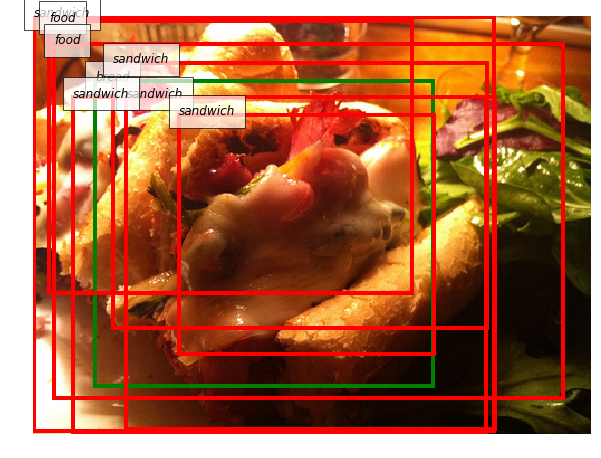

In [24]:
index = 8000
row = infdf.iloc[index]
plot_labelled_bb(vgpath+str(row.img_id)+'.jpg', labeled_bbs(infdf, row.obj_id_a))

In [25]:
labeled_bbs(infdf, 1365136)

[([0, 215, 171, 285], ('jacket', 'g')), ([9, 197, 185, 303], ('man', 'r')), ([9, 197, 185, 303], ('person', 'r'))]


[([0, 215, 171, 285], ('jacket', 'g')),
 ([9, 197, 185, 303], ('man', 'r')),
 ([9, 197, 185, 303], ('person', 'r'))]

In [26]:
dedupedf = infdf.drop_duplicates(subset='img_id obj_id_a name_b'.split())

In [27]:
len(dedupedf)

8051

5903 img_id                                                    2345205
obj_id_a                                                  3382179
obj_id_b                                                  3912969
name_a                                                       bird
name_b                                                    seagull
bb_a                                           [30, 87, 312, 177]
bb_b                                           [27, 84, 230, 175]
spellchecked    {'pelican': 1, 'bird': 23, 'birds': 4, 'seagul...
Name: 11278, dtype: object
[([30, 87, 312, 177], ('bird', 'g')), ([38, 59, 290, 223], ('birds', 'r')), ([27, 84, 230, 175], ('seagull', 'r'))]


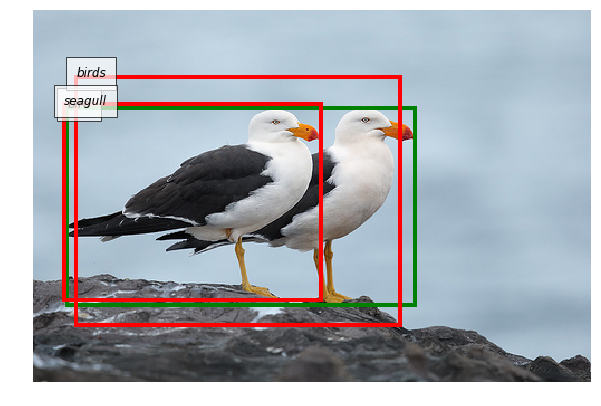

In [54]:
index = np.random.randint(0,len(dedupedf))
row = dedupedf.iloc[index]
print(index, row)
plot_labelled_bb(vgpath+str(row.img_id)+'.jpg', labeled_bbs(dedupedf, row.obj_id_a))